# Implementación y contraste de algoritmos de pronóstico de generación para una planta solar fotovoltaica de 80 kW de la Universidad de Los Andes

## Diego Andrés Acosta y Robinson Julián Portilla

#### En este proyecto de grado se realiza el pronóstico de generación del día siguiente de una planta solar fotovoltaica de 80 kW de la Universidad de Los Andes mediante diferentes algoritmos de Machine Learning. 

#### Se importan las librerías a utilizar jjdjdlklklldk

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
from scipy import stats

## Pre-Procesamiento de Datos

En esta etapa se realiza el pre-procesamiento de los datos empleados para realizar los modelos de pronóstico.

Los datos se encuentran en la carpeta '/DATOS SOLAR' de este repositorio. Los datos tienen una resolución de 5 minutos y consisten en la fecha (dd/mm/aa), hora (hh:mm), Potencia generada (kW), irradiación solar (W/m^2), Temperatura de los modulos (°C), Temperatura ambiente (°C) e irradiación solar media (W/m^2). Se consideraron los datos de octubre de 2019 a diciembre de 2020 para realizar el entrenamiento y evaluación de los modelos implementados. 

Cabe señalar que, puesto que la estación meteorológica de la planta no otorga datos de temperatura ambiente, esta fue estimada mediante la siguiente expresión:

#### Tamb=Tcelda-G*(TONC-20°C)/800W/m^2

Donde: 
- G es la irradiación en ese momento en W/m^2
- TONC es la temperatura nominal de la celda en °C, la cual es de 42°C para los paneles LG 400W de la planta
- Tcelda es la temperatura de los modulos fotovoltaicos en °C en ese momento
- Tamb es la temperatura ambiente en °C 

Además, con el fin de mejorar el pronóstico de los modelos de series de tiempo, se suaviazan los datos de temperatura ambiente y de insolación solar mediante un promedio móvil de ventana 11. La columna Insolación solar media corresponde a los datos de Insolación solar suaviazados.  

### Lectura de datos:
En esta etapa se leen los datos almacenados en la carpeta '/DATOS SOLAR':

In [35]:
ruta = 'C:\\Users\\USUARIO\\OneDrive\\Universidad\\Proyecto de Grado\\Repositorio\\Proyecto-Electronica\\DATOS SOLAR\\'
ruta2='C:\\Users\Diego Acosta\\Documents\\GitHub\\Proyecto-Electronica\\DATOS SOLAR\\'
mes = input('Ingrese el mes: ')
año = input('Ingrese el año: ')
try:
    datos = pd.read_csv(ruta + mes + ' ' + año + '.csv')
except:
    datos = pd.read_csv(ruta2 + mes + ' ' + año + '.csv')
datos

Ingrese el mes: Junio
Ingrese el año: 2020


,Fecha,Hora,Potencia [kW],Insolacion [W/m2],Temperatura de modulos [C],Temperatura ambiente [C],Insolacion media [W/m2]
0,1/06/2020,0:00,x,0.99,12.66,12.291292,0.983333
1,1/06/2020,0:05,x,0.99,12.38,12.291543,0.982857
2,1/06/2020,0:10,x,0.98,12.19,12.311697,0.983750
3,1/06/2020,0:15,x,0.98,12.14,12.312928,0.984444
4,1/06/2020,0:20,x,0.98,12.26,12.283940,0.984000
...,...,...,...,...,...,...,...
8923,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8924,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8925,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8926,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Funciones para el pre procesamiento: 

In [198]:
#Esta función reemplaza los datos ue tengan un valor de 'x' por un 0

def reemplazo(datos):
    datos.replace({'Potencia [kW]':'x'},0,inplace = True)
    datos.dropna(inplace = True)
    return datos

#Esta función toma los valores donde se observa que el sol está activo
# el intervalo de horas tomado es en un día de 6:00 am a 6:00pm. Además,
#en esta función se cambian algunos valores de temperatura ambiente 
#considerados fuera de lo normal para la ciudad de Bogotá

def intervalosolar(datos):
    list1 = datos['Hora'][0:72].tolist()
    list2 = datos['Hora'][217:288].tolist()
    
    list = list1+list2
    
    t = datos[datos['Hora']==horas[1]].columns.values[-2]
    for i in range(len(list)):
        datos = datos[datos['Hora']!= list[i]]
        
    for i in datos[t]:   
        if 14< i<16:
            datos.replace({t:i},i*0.9,inplace=True)
        elif 16<i<18:
            datos.replace({t:i},i*0.85,inplace=True)
        elif i>18:
            datos.replace({t:i},i*0.75,inplace=True)
            
    return datos

#En esta función se guarda el dataframe pre procesado en formato .csv
#en una carpeta nueva llamada '/Pre- procesados'

rutanueva = 'C:\\Users\\USUARIO\\OneDrive\\Universidad\\Proyecto de Grado\\Repositorio\\Proyecto-Electronica\\DATOS SOLAR'

def guardarcsv(datos,nombre):
    datos.to_csv(rutanueva+'\\Pre procesados\\'+ nombre)
    

#### Se crea una lista donde se guardan las rutas de los archivos a leer:

In [200]:
archivos = glob.glob('C:\\Users\\USUARIO\\OneDrive\\Universidad\\Proyecto de Grado\\Repositorio\\Proyecto-Electronica\\DATOS SOLAR\\*.csv')
if archivos==[]:
    archivos = glob.glob('C:\\Users\\Diego Acosta\\Documents\\GitHub\\Proyecto-Electronica\\DATOS SOLAR\\*.csv')    

nombres = [] #Vector con los nombres de los archivos

for i in range(len(archivos)):
    nombre = archivos[i].split('\\')
    nombres.append(nombre[-1])
nombres

['Abril 2020.csv',
 'Agosto 2020.csv',
 'Diciembre 2019.csv',
 'Diciembre 2020.csv',
 'Enero 2020.csv',
 'Febrero 2020.csv',
 'Julio 2020.csv',
 'Junio 2020.csv',
 'Marzo 2020.csv',
 'Mayo 2020.csv',
 'Noviembre 2019.csv',
 'Noviembre 2020.csv',
 'Octubre 2019.csv',
 'Octubre 2020.csv',
 'Septiembre 2020.csv']

### Ejecución de funciones:

#### Se lee cada uno de los archivos y se ejecutan las diferentes funciones definidas previamente:

In [201]:
for i in range(len(archivos)):
    #Se lee el archivo de la ruta
    datos = pd.read_csv(archivos[i])
    datos = reemplazo(datos)
    datos = intervalosolar(datos)
    guardarcsv(datos, nombres[i])


In [215]:
datos[0:145]

,Fecha,Hora,Potencia [kW],Insolacion [W/m2],Temperatura de modulos [C],Temperatura ambiente [C],Insolacion media [W/m2]
72,1/09/2020,6:00,0.01,5.08,9.64,9.399891,6.880000
73,1/09/2020,6:05,0.08,7.02,9.53,9.407027,8.934545
74,1/09/2020,6:10,0.17,9.42,9.40,9.437618,11.789091
75,1/09/2020,6:15,0.29,11.87,9.38,9.478893,15.015455
76,1/09/2020,6:20,0.44,14.96,9.52,9.524152,18.493636
...,...,...,...,...,...,...,...
212,1/09/2020,17:40,2.48,43.63,18.58,13.645679,28.440909
213,1/09/2020,17:45,1.02,21.37,18.53,15.291960,24.310909
214,1/09/2020,17:50,0.3,9.74,18.38,15.092457,20.449091
215,1/09/2020,17:55,0.97,20.52,18.34,14.852009,17.082727


#### Se muestra un ejemplo de cómo queda el dataframe final:

,Fecha,Hora,Potencia [kW],Insolacion [W/m2],Temperatura de modulos [C],Temperatura ambiente [C],Insolacion media [W/m2]
4968,18/09/2020,6:00,0.12,8.47,9.58,9.779361,9.973636
4969,18/09/2020,6:05,0.19,10.58,9.63,9.646491,12.458182
4970,18/09/2020,6:10,0.31,13.15,9.71,9.526091,15.381818
4971,18/09/2020,6:15,0.43,16.44,9.79,9.450618,18.952727
4972,18/09/2020,6:20,0.61,20.67,9.96,9.431934,22.871818
...,...,...,...,...,...,...,...
5108,18/09/2020,17:40,0,2.17,13.79,13.770811,2.648182
5109,18/09/2020,17:45,0,1.81,13.95,13.853905,2.238182
5110,18/09/2020,17:50,0,1.83,13.87,13.946716,1.904545
5111,18/09/2020,17:55,0,1.39,14.00,12.625908,1.630909


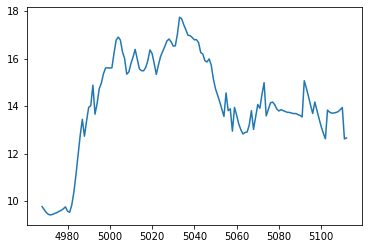

In [226]:
import random
n = random.randrange(30)
plt.plot(datos['Temperatura ambiente [C]'][n*145:n*145+145])
datos[n*145:n*145+145]

## Análisis estadístico y de desempeño de la planta solar fotovoltaica 

En esta sección se realiza el análisis estadístico y de desempeño de los datos de potencia generada, irradiación solar y temperatura ambiente registrados de octubre de 2019 a diciembre de 2020 por la estación meteorológica de la planta solar fotovoltaica. 

In [227]:
# Recibe un dataframe de datos de la planta y la variable a analizar

def soldiario(datos,variable ,variablerango):
    fechas = datos[variablerango].unique()
    solxdia = []
    for i in range(len(fechas)):
        solxdia.append(round(datos[datos[variablerango]==fechas[i]].sum()[variable]/12,3))
    df = {'Dia':fechas, variable:solxdia}
    df = pd.DataFrame(df)
    return df

def tempdiario(datos,variable ,variablerango):
    fechas = datos[variablerango].unique()
    solxdia = []
  
    for i in range(len(fechas)):
        solxdia.append(datos[datos[variablerango]==fechas[i]].sum()[variable])
    df = {'Dia':fechas, variable.lower():solxdia}
    df = pd.DataFrame(df)
    return df

## Lectura de archivos:

### Se crea un vector con las rutas donde se encuentran los archivos preprocesados

In [228]:
ruta = 'C:\\Users\\USUARIO\\OneDrive\\Universidad\\Proyecto de Grado\\Repositorio\\Proyecto-Electronica\\DATOS SOLAR\\Pre procesados\\'
ruta2 = 'C:\\Users\\Diego Acosta\\Documents\\GitHub\\Proyecto-Electronica\\DATOS SOLAR\\Pre procesados\\'
archivospre = glob.glob(ruta2 +'*.csv')
if archivospre==[]:
    archivospre = glob.glob(ruta +'*.csv')
archivospre

['C:\\Users\\USUARIO\\OneDrive\\Universidad\\Proyecto de Grado\\Repositorio\\Proyecto-Electronica\\DATOS SOLAR\\Pre procesados\\Abril 2020.csv',
 'C:\\Users\\USUARIO\\OneDrive\\Universidad\\Proyecto de Grado\\Repositorio\\Proyecto-Electronica\\DATOS SOLAR\\Pre procesados\\Agosto 2020.csv',
 'C:\\Users\\USUARIO\\OneDrive\\Universidad\\Proyecto de Grado\\Repositorio\\Proyecto-Electronica\\DATOS SOLAR\\Pre procesados\\Diciembre 2019.csv',
 'C:\\Users\\USUARIO\\OneDrive\\Universidad\\Proyecto de Grado\\Repositorio\\Proyecto-Electronica\\DATOS SOLAR\\Pre procesados\\Diciembre 2020.csv',
 'C:\\Users\\USUARIO\\OneDrive\\Universidad\\Proyecto de Grado\\Repositorio\\Proyecto-Electronica\\DATOS SOLAR\\Pre procesados\\Enero 2020.csv',
 'C:\\Users\\USUARIO\\OneDrive\\Universidad\\Proyecto de Grado\\Repositorio\\Proyecto-Electronica\\DATOS SOLAR\\Pre procesados\\Febrero 2020.csv',
 'C:\\Users\\USUARIO\\OneDrive\\Universidad\\Proyecto de Grado\\Repositorio\\Proyecto-Electronica\\DATOS SOLAR\\Pre pro

### Se crea un vector con los nombres de los diferentes archivos

In [229]:
nombres2 = []
for i in range(len(archivospre)):
    nombre = archivospre[i].split('\\')
    nombres2.append(nombre[-1])
nombres2

['Abril 2020.csv',
 'Agosto 2020.csv',
 'Diciembre 2019.csv',
 'Diciembre 2020.csv',
 'Enero 2020.csv',
 'Febrero 2020.csv',
 'Julio 2020.csv',
 'Junio 2020.csv',
 'Marzo 2020.csv',
 'Mayo 2020.csv',
 'Noviembre 2019.csv',
 'Noviembre 2020.csv',
 'Octubre 2019.csv',
 'Octubre 2020.csv',
 'Septiembre 2020.csv']

## Histograma de irradiación solar diaria:

#### Se crea un dataframe llamado 'todo' que contiene los datos  por día de una variable específica de los dataframes pre procesados anteriormente

In [248]:
i=0
variable = 'Insolacion [W/m2]'
#variable = 'Potencia [kW]'
variablerango = 'Fecha'

for nombre in nombres2:
    df = pd.read_csv(nombre)

    try: 
        df = df.drop('Unnamed: 0',axis=1)
    except:
        pass

    df = df.dropna()

    name = nombre.split('.') 
    name = name[0].split(' ')

    globals()[name[0] + name[1]] = soldiario(df,variable,variablerango)

    if i == 0:
        todoIns = globals()[name[0] + name[1]] # DataFrame donde se guardan los diferentes valores de insolación por día.
    else:
        todoIns = pd.concat([todoIns , globals()[name[0] + name[1]]],axis = 0)
    i+=1
todoIns

,Dia,Insolacion [W/m2]
0,1/04/2020,1473.167
1,2/04/2020,4900.995
2,3/04/2020,5215.679
3,4/04/2020,2379.293
4,5/04/2020,3835.619
...,...,...
25,26/09/2020,3373.524
26,27/09/2020,3438.583
27,28/09/2020,3485.870
28,29/09/2020,4305.051


In [260]:
df.iloc[:,:8]

,Fecha,Hora,Potencia [kW],Insolacion [W/m2],Temperatura de modulos [C],Temperatura ambiente [C],Insolacion media [W/m2]
0,1/09/2020,6:00,0.01,5.08,9.64,9.399891,6.880000
1,1/09/2020,6:05,0.08,7.02,9.53,9.407027,8.934545
2,1/09/2020,6:10,0.17,9.42,9.40,9.437618,11.789091
3,1/09/2020,6:15,0.29,11.87,9.38,9.478893,15.015455
4,1/09/2020,6:20,0.44,14.96,9.52,9.524152,18.493636
...,...,...,...,...,...,...,...
4345,30/09/2020,17:40,0.17,8.58,15.75,13.457197,13.696364
4346,30/09/2020,17:45,0.00,3.21,15.58,13.198977,10.542727
4347,30/09/2020,17:50,0.00,1.75,15.54,12.935315,7.807273
4348,30/09/2020,17:55,0.00,1.07,14.91,12.680530,4.845455


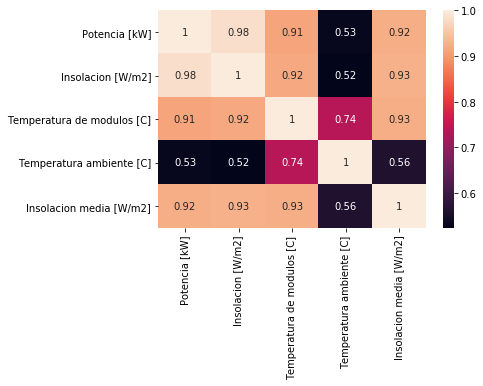

In [261]:
import seaborn as sns

# taking all rows but only 6 columns
df_small = df.iloc[:,:8]

correlation_mat = df_small.corr()

sns.heatmap(correlation_mat, annot = True)

plt.show()

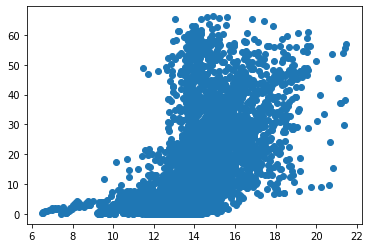

In [258]:
plt.scatter(df['Temperatura ambiente [C]'],df['Potencia [kW]'])

### Gráfica

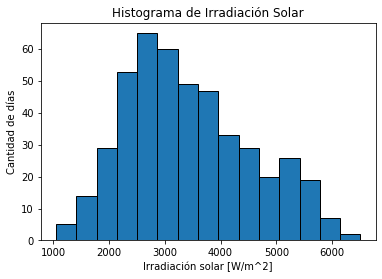

In [231]:
plt.hist(todoIns['Insolacion [W/m2]'],15,ec = 'k') #Histograma de frecuencias de insolación diaria media
plt.xlabel('Irradiación solar [W/m^2]')
plt.ylabel('Cantidad de días')
plt.title('Histograma de Irradiación Solar')
plt.show()


### Estimación de la distribución que mejor se adapta al histograma anterior:

In [244]:
mu = np.mean(todoIns['Insolacion [W/m2]'])
desv = np.std(todoIns['Insolacion [W/m2]'])
sigma = np.var(todoIns['Insolacion [W/m2]'])
mu,sigma,desv
statsT = pd.DataFrame({'Media':[mu],'Varianza':[sigma],'Desv. Estándar':[desv]})
statsT

,Media,Varianza,Desv. Estándar
0,3433.733886,1.247964e+06,1117.122998


In [233]:
todoIns['Insolacion [W/m2]'].sum()/458

3433.7338864628823

## Histograma de Temperaturas medias por hora:

In [247]:
datos = pd.read_csv('Octubre 2020.csv')
datos[datos['Hora']==horas[1]].columns.values[-2]
horas = datos['Hora'].unique()
horas

array(['6:00', '6:05', '6:10', '6:15', '6:20', '6:25', '6:30', '6:35',
       '6:40', '6:45', '6:50', '6:55', '7:00', '7:05', '7:10', '7:15',
       '7:20', '7:25', '7:30', '7:35', '7:40', '7:45', '7:50', '7:55',
       '8:00', '8:05', '8:10', '8:15', '8:20', '8:25', '8:30', '8:35',
       '8:40', '8:45', '8:50', '8:55', '9:00', '9:05', '9:10', '9:15',
       '9:20', '9:25', '9:30', '9:35', '9:40', '9:45', '9:50', '9:55',
       '10:00', '10:05', '10:10', '10:15', '10:20', '10:25', '10:30',
       '10:35', '10:40', '10:45', '10:50', '10:55', '11:00', '11:05',
       '11:10', '11:15', '11:20', '11:25', '11:30', '11:35', '11:40',
       '11:45', '11:50', '11:55', '12:00', '12:05', '12:10', '12:15',
       '12:20', '12:25', '12:30', '12:35', '12:40', '12:45', '12:50',
       '12:55', '13:00', '13:05', '13:10', '13:15', '13:20', '13:25',
       '13:30', '13:35', '13:40', '13:45', '13:50', '13:55', '14:00',
       '14:05', '14:10', '14:15', '14:20', '14:25', '14:30', '14:35',
       '14:40'

In [235]:
temps = np.zeros(len(horas))
cont = 0
for nombre in nombres2:
    datos = pd.read_csv(nombre)
    
    t = datos[datos['Hora']==horas[1]].columns.values[-2]#Columna donde está almacenada la temperatura
    
    cont = cont + len(datos[datos['Hora']==horas[1]])    #Contador de días
    
    for i in range(len(horas)):
        temps[i] = temps[i] + datos[datos['Hora']==horas[i]][t].sum()#Actualización del vector de temperaturas

todoTemp = pd.DataFrame({'Hora':horas,'Temperatura media [C]':temps/cont})

In [236]:
todoTemp

,Hora,Temperatura media [C]
0,6:00,10.950039
1,6:05,10.964538
2,6:10,10.983795
3,6:15,11.009460
4,6:20,11.042430
...,...,...
140,17:40,13.709169
141,17:45,13.677863
142,17:50,13.620232
143,17:55,13.559291


### Gráfica

(array([ 8.,  3.,  2.,  2.,  2.,  2.,  2.,  8., 15., 17., 10., 12., 16.,
        18., 28.]),
 array([10.95003872, 11.30098853, 11.65193833, 12.00288814, 12.35383795,
        12.70478776, 13.05573756, 13.40668737, 13.75763718, 14.10858698,
        14.45953679, 14.8104866 , 15.1614364 , 15.51238621, 15.86333602,
        16.21428582]),
 <a list of 15 Patch objects>)

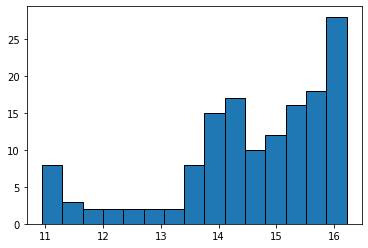

In [237]:
plt.hist(todoTemp['Temperatura media [C]'],15,ec = 'k')

In [243]:
muT = np.mean(todoTemp['Temperatura media [C]'])
desvT = np.std(todoTemp['Temperatura media [C]'])
sigmaT = np.var(todoTemp['Temperatura media [C]'])

muT,sigmaT,desvT
todoTemp['Temperatura media [C]'].describe()
statsT = pd.DataFrame({'Media':[muT],'Varianza':[sigmaT],'Desv. Estándar':[desvT]})
statsT

,Media,Varianza,Desv. Estándar
0,14.575088,1.960852,1.400304


## Histograma 

In [148]:
i=0
#variable = 'Insolacion [W/m2]'
variable = 'Potencia [kW]'
variablerango = 'Fecha'

for nombre in nombres2:
    df = pd.read_csv(nombre)

    try: 
        df = df.drop('Unnamed: 0',axis=1)
    except:
        pass

    df = df.dropna()

    name = nombre.split('.') 
    name = name[0].split(' ')

    globals()[name[0] + name[1]] = soldiario(df,variable,variablerango)

    if i == 0:
        todo = globals()[name[0] + name[1]] # DataFrame donde se guardan los diferentes valores de insolación por día.
    else:
        todo = pd.concat([todo , globals()[name[0] + name[1]]],axis = 0)
    i+=1
todo

,Dia,Potencia [kW]
0,1/04/2020,88.374167
1,2/04/2020,278.395833
2,3/04/2020,285.022500
3,4/04/2020,151.040000
4,5/04/2020,227.030833
...,...,...
25,26/09/2020,183.883333
26,27/09/2020,166.640000
27,28/09/2020,175.900000
28,29/09/2020,229.958333


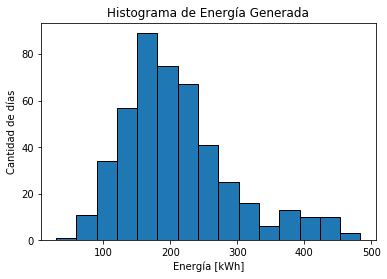

In [151]:
plt.hist(todo['Potencia [kW]'],15,ec = 'k') 
plt.xlabel('Energía [kWh]')
plt.ylabel('Cantidad de días')
plt.title('Histograma de Energía Generada')
plt.show()